# Regularización - Optimización - Feature Engineering - Pipelines

## Planteo del Problema

El problema que vamos a tratar de resolver es de predecir el salario de un jugador de la NBA de la temporada 2019-2020 en base a sus estadísticas de juego durante la temporada

Las técnicas de regularización son útiles para trabajar con conjuntos con gran cantidad de variables, las cuales pueden introducir variabilidad en las estimaciones de los parámetros.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

In [13]:
#seed definition
seed = 1911

## Conjunto de datos

The data comes from the Basketball Reference page and was previously worked on by us to obtain the current format.
The set variables are:

In [14]:
dictionary = pd.read_excel('https://datasets-humai.s3.amazonaws.com/datasets/diccionario_terminos.xlsx')
dictionary

,variable,descripcion
0,player,nombre
1,salary,Salario
2,position,Posicion en el campo de juego
3,age,Edad
4,team_id,Nombre del Equipo
5,g,Cantidad de Partidos
6,gs,Partidos como titular
7,mp_per_g,minutos por partido
8,fg_per_g,Tiros de campo por partido (dobles y triples)
9,fga_per_g,Intentos de tiro de campo


In [15]:
nba = pd.read_csv('https://datasets-humai.s3.amazonaws.com/datasets/nba_salarios_2021.csv')

In [16]:
#cleaning some varibles
nba['position'] = nba['position'].str.replace('-.*','')
nba = nba.fillna(0)

In [17]:
#show the information of dataset
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   player      403 non-null    object 
 1   salary      403 non-null    float64
 2   position    403 non-null    object 
 3   age         403 non-null    int64  
 4   team_id     403 non-null    object 
 5   g           403 non-null    int64  
 6   gs          403 non-null    int64  
 7   mp_per_g    403 non-null    float64
 8   fg_per_g    403 non-null    float64
 9   fga_per_g   403 non-null    float64
 10  fg_pct      403 non-null    float64
 11  fg3_per_g   403 non-null    float64
 12  fg3a_per_g  403 non-null    float64
 13  fg3_pct     403 non-null    float64
 14  fg2_per_g   403 non-null    float64
 15  fg2a_per_g  403 non-null    float64
 16  fg2_pct     403 non-null    float64
 17  efg_pct     403 non-null    float64
 18  ft_per_g    403 non-null    float64
 19  fta_per_g   403 non-null    f

## 1. Exploratory analysis

### Position vs. Salary Graph

Veamos como es la distribución de salarios según la posición de juego. Se agregan las etiquetas de los jugadores que cobran mayores sueldos buscar forma de agregar labels no muy compleja

In [18]:
def boxplots_2v(xlabel="position",ylabel="salary", data=nba):
    fig, ax = plt.subplots(figsize=(10,7))
    ax = sns.boxplot(x=xlabel, y=ylabel, data=data)
    ax.set_title(f'Boxplots: {ylabel} y  {xlabel}', fontweight='bold', fontsize=20, y=1.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='y', linestyle='--')
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xlabel(xlabel, fontsize=10)
    plt.show()

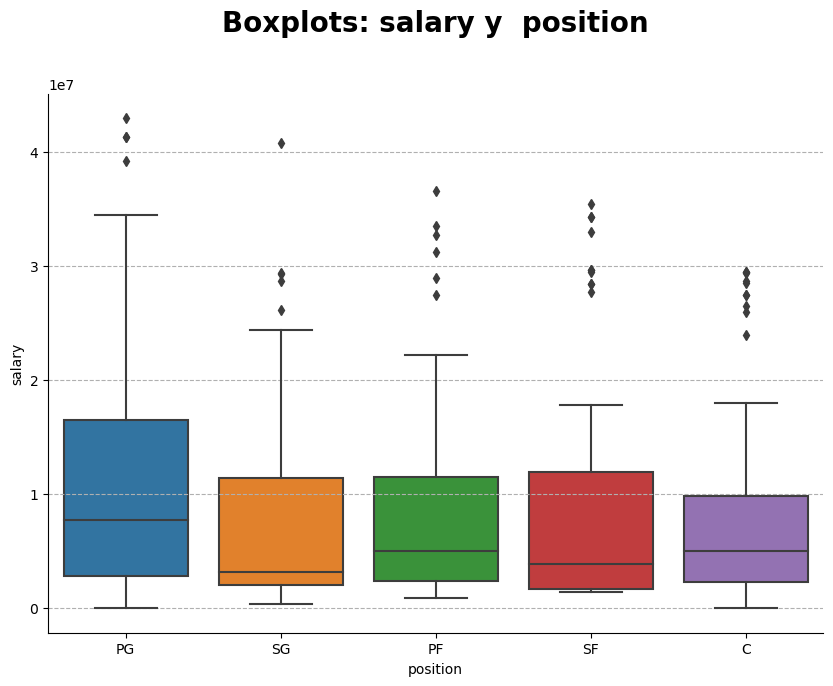

In [19]:
boxplots_2v(xlabel="position",ylabel="salary", data=nba)

We note that the distribution varies a bit between positions and there are several players who are outliers.

### Correlogram

We made a correlogram between all the quantitative variables

In [20]:
# We get the numeric variables and ganerate the correlation matrix
nba_numeric = nba.select_dtypes(include=['float64','int64'])
correlation_matrix = nba_numeric.corr()

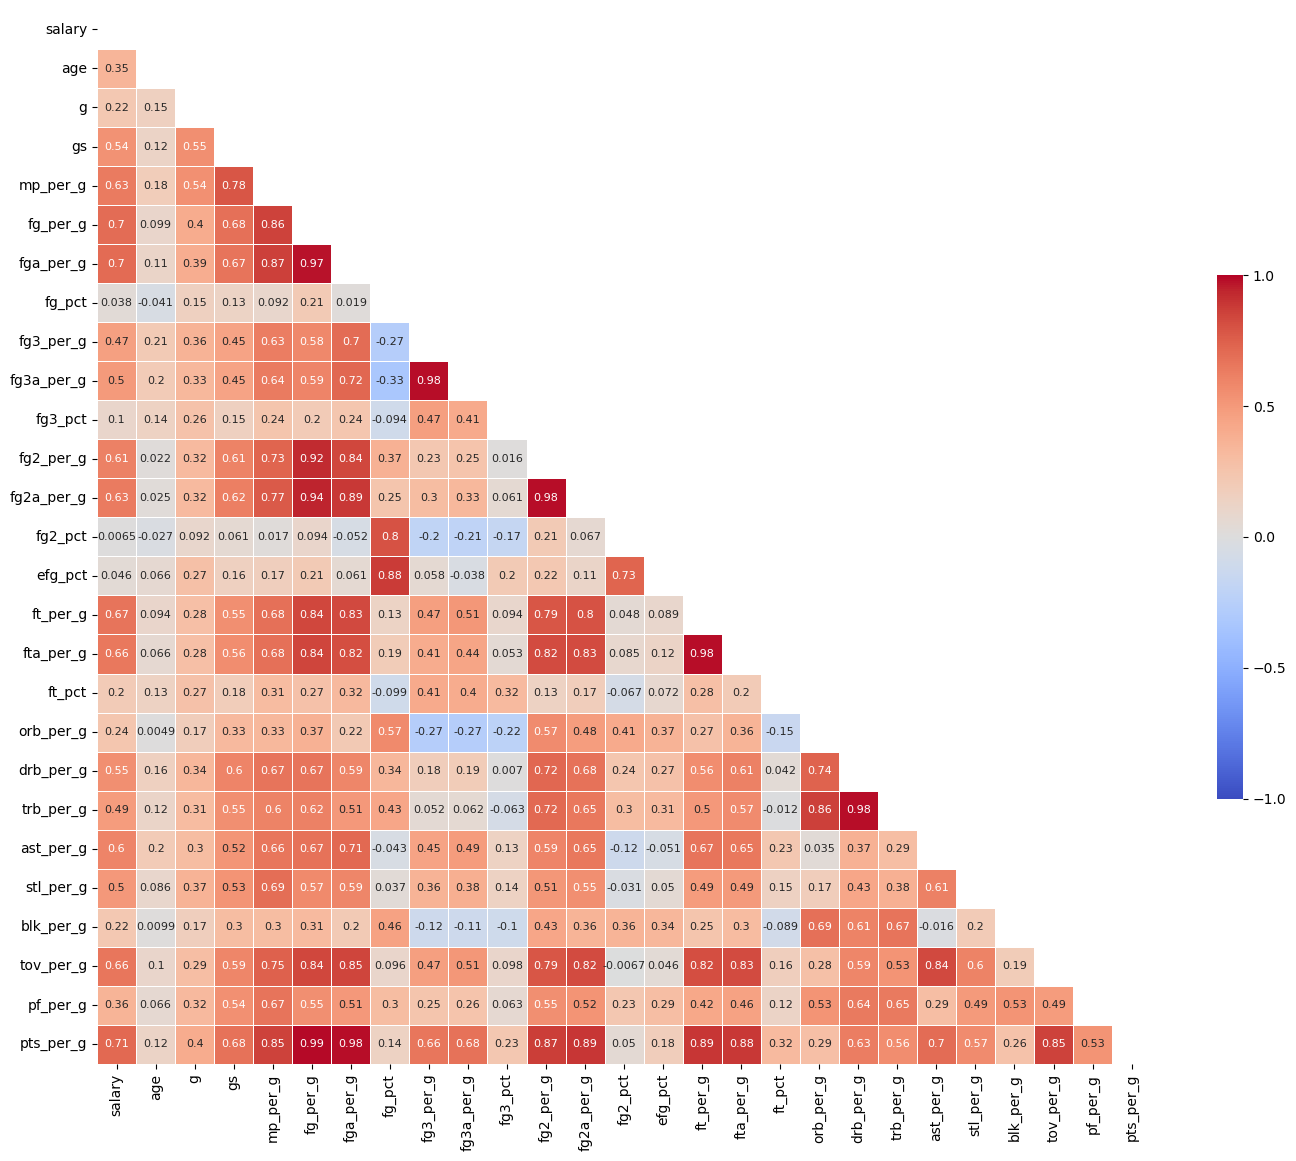

In [24]:

mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(17, 17))

heatmap = sns.heatmap(correlation_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True, annot_kws={"fontsize":8})


ax.set_yticklabels(correlation_matrix.columns, rotation = 0)
ax.set_xticklabels(correlation_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [11]:
def matrix_corr_graph(correlation_matrix):
    mask = np.zeros_like(correlation_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True
    f, ax = plt.subplots(figsize=(17, 17))
    heatmap = sns.heatmap(correlation_matrix,
                          mask = mask,
                          square = True,
                          linewidths = .5,
                          cmap = 'coolwarm',
                          cbar_kws = {'shrink': .4,
                                    'ticks': [-1, -.5, 0, 0.5, 1]},
                          vmin = -1,
                          vmax = 1,
                          annot = True, annot_kws={"fontsize":8})
    ax.set_yticklabels(correlation_matrix.columns, rotation = 0)
    ax.set_xticklabels(correlation_matrix.columns)
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})


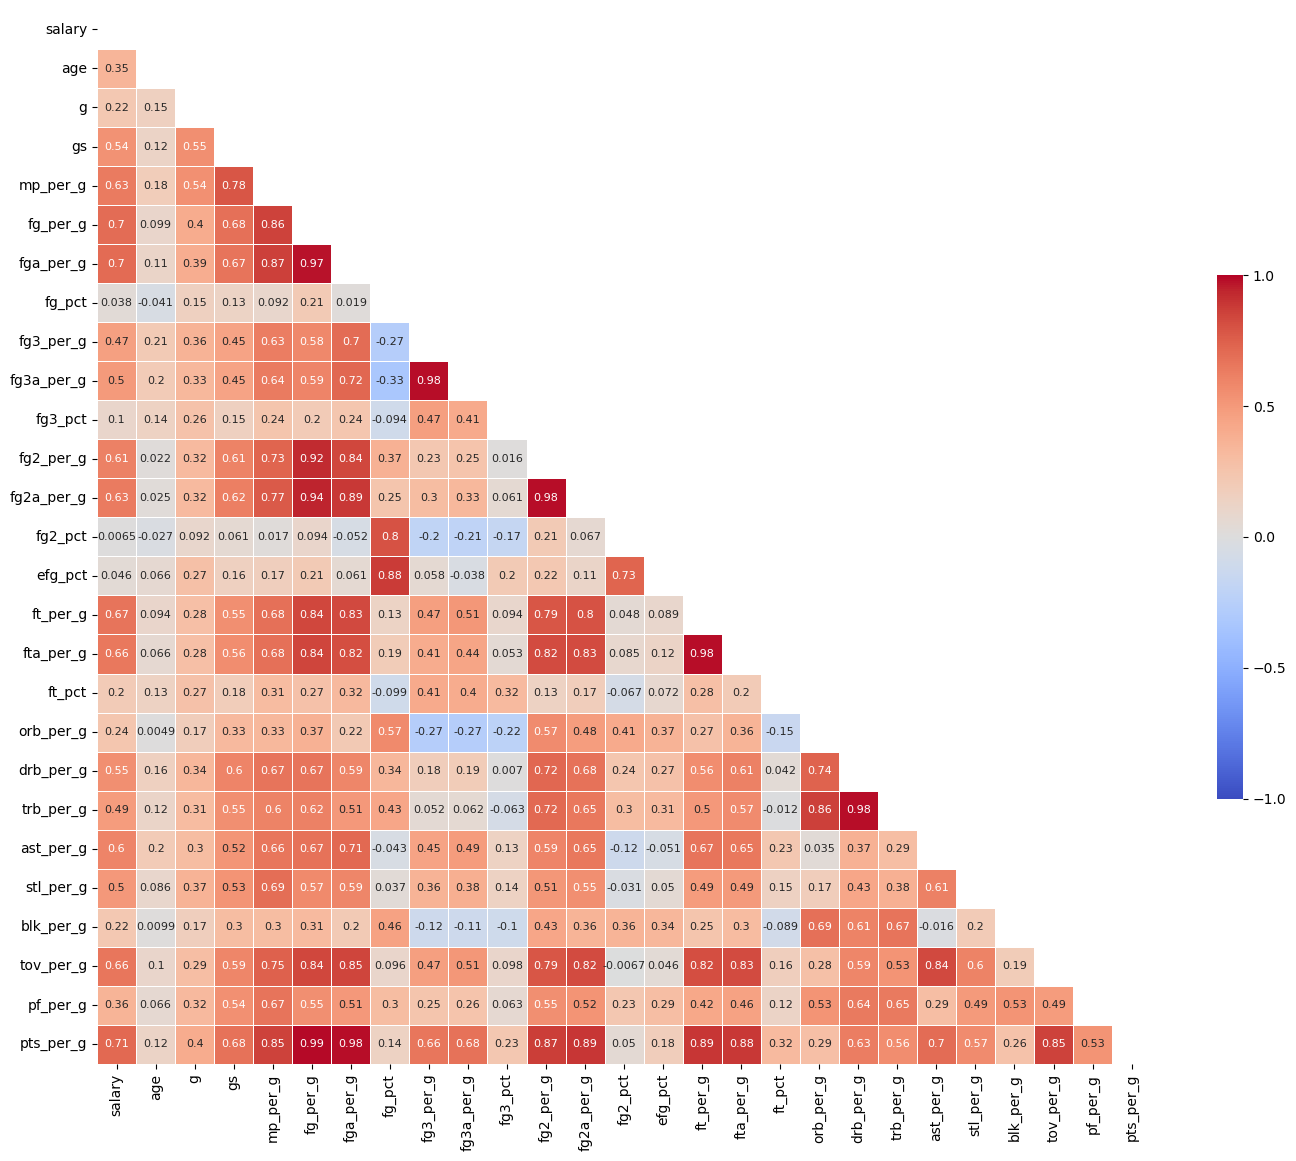

In [25]:
matrix_corr_graph(correlation_matrix)

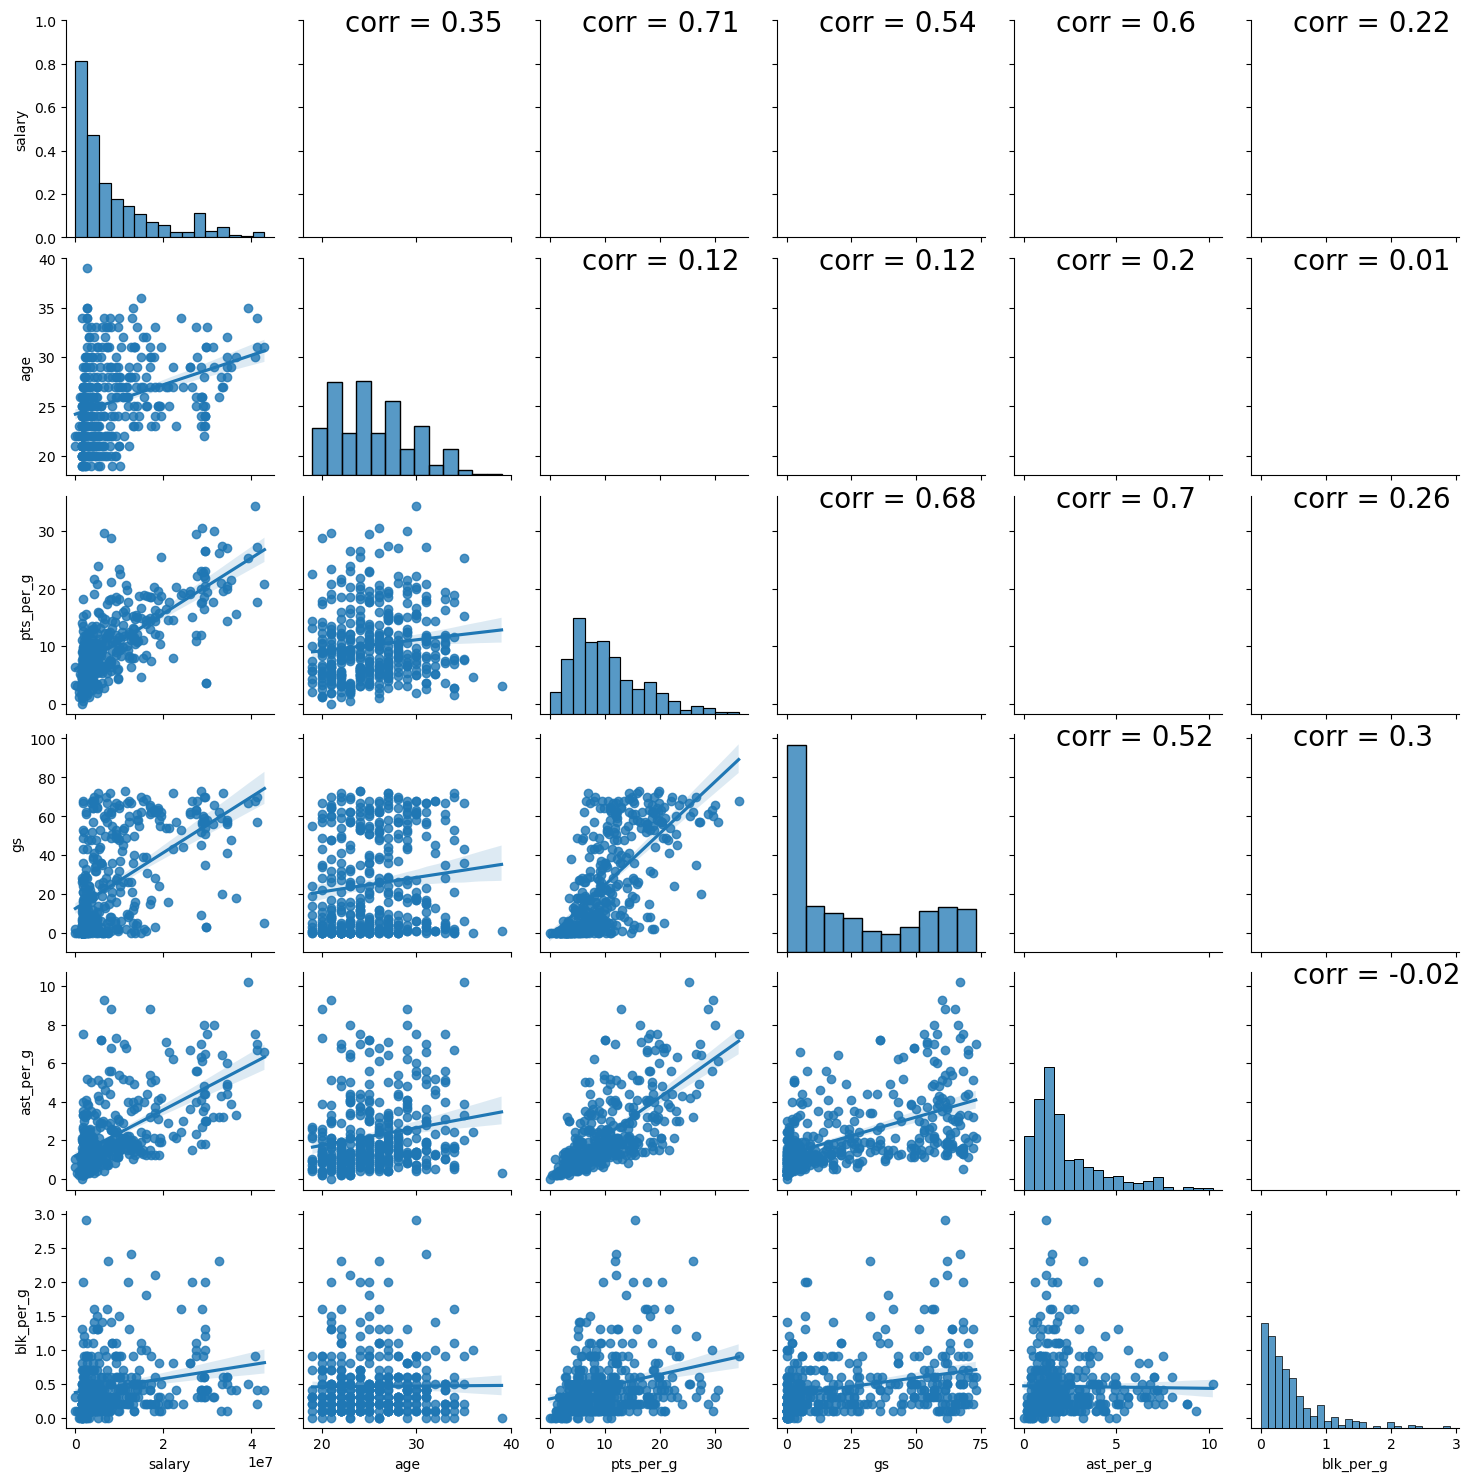

In [33]:
nba_numeric_selected = nba_numeric[['salary','age','pts_per_g','gs','ast_per_g','blk_per_g']]

def corr(x, y, **kwargs):
    coef = np.corrcoef(x, y)[0][1]
    # we geenrate th targets
    label = r'corr = ' + str(round(coef, 2))
    
    # We add targets
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    

g = sns.PairGrid(nba_numeric_selected)
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)
g.map_upper(corr)

It can be seen that salary is positively correlated with all variables. You can also see a positive correlation between **pts_per_g** (points per game) and **ast_per_g** (assist per game)

## **2. Linear model**

We are going to fit a linear model that includes all the variables (except the name of the player and the team) and we will obtain all the parameters of the model together with the value of their confidence interval

$E(salary|X) = X \beta$

$y_{salary} = X \beta$

$y_{salary} = \beta_0 + \beta_1  x_{age} + \beta_2  x_{position} + \beta_3  x_{g} + ... + \beta_n  x_{ptsperg} $

### Creating the dummy variables

To create the dummy variables we are going to use the transformer (it is a type of class) OneHotEncoder. The arguments we are going to use are:

* **categories:** la lista de categorías que tiene la variable categórica
* **drop='first':** indica que se va a "tirar" la primera categoría (es la que queda contenida en el intercepto)

### Coeficientes estimados

We create the model and access the information of the coefficients

In [36]:
nba_linal = nba.copy()

In [37]:
nba_linal = nba_linal.drop(['player','team_id'],axis=1)

In [38]:
#select numeric variables:
nba_linal_numeric = nba_linal.select_dtypes(include=['float64','int64'])

In [39]:
#categorical variables
nba_linal_categorical = nba_linal.select_dtypes(include=['object'])

In [51]:
categories_array = [nba_linal_categorical['position'].unique()]
categories_array

[array(['PG', 'SG', 'PF', 'SF', 'C'], dtype=object)]

In [41]:
from sklearn.preprocessing import OneHotEncoder

In [52]:
#we define the instance of the transformer
one_hot_enconder = OneHotEncoder(categories=categories_array, drop='first')

In [53]:
#We realized the fit with the data of training
one_hot_enconder.fit(nba_linal_categorical[['position']])

OneHotEncoder(categories=[array(['PG', 'SG', 'PF', 'SF', 'C'], dtype=object)],
              drop='first')

In [54]:
# Get the categories from the encoder
one_hot_enconder.categories_

[array(['PG', 'SG', 'PF', 'SF', 'C'], dtype=object)]

In [56]:
# We generate the dummy variables from the property type variable (note that we have 2 columns!)
dummies_array = one_hot_enconder.transform(nba_linal_categorical[['position']]).toarray()
dummies_array

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [58]:
dummies_names = one_hot_enconder.get_feature_names_out(['position'])

In [59]:
dummies_names

array(['position_SG', 'position_PF', 'position_SF', 'position_C'],
      dtype=object)

In [57]:
#generate dataframe of dummies variable:

In [60]:
df_dummies = pd.DataFrame(dummies_array,columns=dummies_names, index=nba_linal_categorical.index)

In [62]:
df_dummies.head(10)

,position_SG,position_PF,position_SF,position_C
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0
6,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0


In [63]:
#We remove the predictor variable
nba_linal = pd.concat([nba_linal_numeric, df_dummies], axis=1)
X = nba_linal.drop(['salary'],axis=1)
lineal_features_array = X.columns
y = nba_linal['salary']


In [64]:
X.head()

,age,g,gs,mp_per_g,fg_per_g,fga_per_g,fg_pct,fg3_per_g,fg3a_per_g,fg3_pct,...,ast_per_g,stl_per_g,blk_per_g,tov_per_g,pf_per_g,pts_per_g,position_SG,position_PF,position_SF,position_C
0,31,5,5,27.8,6.6,16.4,0.402,2.4,9.8,0.245,...,6.6,1.0,0.4,3.2,2.2,20.8,0.0,0.0,0.0,0.0
1,31,57,57,35.9,10.6,22.5,0.472,1.0,3.7,0.258,...,7.0,1.6,0.4,4.5,3.5,27.2,0.0,0.0,0.0,0.0
2,34,70,70,31.5,6.2,12.7,0.489,1.6,4.3,0.365,...,6.7,1.6,0.2,2.3,2.3,17.6,0.0,0.0,0.0,0.0
3,30,68,68,36.5,9.9,22.3,0.444,4.4,12.4,0.355,...,7.5,1.8,0.9,4.5,3.3,34.3,1.0,0.0,0.0,0.0
4,35,67,67,34.6,9.6,19.4,0.493,2.2,6.3,0.348,...,10.2,1.2,0.5,3.9,1.8,25.3,0.0,0.0,0.0,0.0


In [65]:
y.head()

0    43006362.0
1    41358814.0
2    41358814.0
3    40824000.0
4    39219565.0
Name: salary, dtype: float64

In [66]:
# we import statistical library
import statsmodels.api as sm
from statsmodels.api import add_constant

In [67]:
# We build the model by adding a constant
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

In [68]:
print(f"MSE: {results.mse_resid}")

MSE: 31832279898386.098


In [70]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     24.78
Date:                Sat, 01 Jul 2023   Prob (F-statistic):           8.41e-71
Time:                        12:11:43   Log-Likelihood:                -6820.6
No. Observations:                 403   AIC:                         1.370e+04
Df Residuals:                     372   BIC:                         1.383e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.341e+07    4.1e+06     -3.271      0.001   -2.15e+07   -5.35e+06
age          5.533e+05   7.82e+04      7.071      0.000    3.99e+05    7.07e+05
g           -5.699e+04   1.98e+04     -2.871      0.004    -9.6e+04    -1.8e+04
gs           4.189e+04   1.98e+04      2.117      0.035    2980.828    8.08e+04
mp_per_g    -1.689e+05    1.2e+05     -1.411      0.159   -4.04e+05    6.64e+04
fg_per_g     4.826e+06   9.05e+06      0.533      0.594    -1.3e+07    2.26e+07
fga_per_g    2.052e+07   6.37e+06      3.220      0.001    7.99e+06    3.31e+07
fg_pct       7.812e+06   1.89e+07      0.413      0.680   -2.94e+07     4.5e+07
fg3_per_g   -7.211e+06   8.03e+06     -0.898      0.370    -2.3e+07    8.58e+06
fg3a_per_g  -1.905e+07   6.37e+06     -2.992      0.003   -3.16e+07   -6.53e+06
fg3_pct     -2.023e+06   3.14e+06     -0.644      0.520    -8.2e+06    4.16e+06
fg2_per_g    -5.45e+06   6.78e+06     -0.804      0.422   -1.88e+07    7.88e+06
fg2a_per_g  -2.022e+07   6.42e+06     -3.149      0.002   -3.29e+07    -7.6e+06
fg2_pct     -2.025e+06    7.7e+06     -0.263      0.793   -1.72e+07    1.31e+07
efg_pct     -6.329e+06   1.82e+07     -0.348      0.728   -4.21e+07    2.95e+07
ft_per_g     2.373e+06   3.96e+06      0.599      0.550   -5.42e+06    1.02e+07
fta_per_g   -1.613e+06   1.25e+06     -1.290      0.198   -4.07e+06    8.45e+05
ft_pct      -5.737e+05    2.6e+06     -0.221      0.825   -5.68e+06    4.53e+06
orb_per_g    6.872e+06    6.2e+06      1.109      0.268   -5.31e+06    1.91e+07
drb_per_g    7.157e+06   6.13e+06      1.168      0.244   -4.89e+06    1.92e+07
trb_per_g   -6.304e+06   6.12e+06     -1.031      0.303   -1.83e+07    5.72e+06
ast_per_g    9.666e+05   3.86e+05      2.506      0.013    2.08e+05    1.73e+06
stl_per_g    3.762e+06   1.13e+06      3.331      0.001    1.54e+06    5.98e+06
blk_per_g    5.363e+05   1.03e+06      0.522      0.602   -1.48e+06    2.56e+06
tov_per_g   -7.605e+05   1.04e+06     -0.733      0.464    -2.8e+06    1.28e+06
pf_per_g    -1.402e+06   6.52e+05     -2.151      0.032   -2.68e+06   -1.21e+05
pts_per_g    6.471e+05    3.8e+06      0.170      0.865   -6.83e+06    8.13e+06
position_SG  1.198e+06   1.13e+06      1.060      0.290   -1.02e+06    3.42e+06
position_PF  2.594e+06   1.33e+06      1.947      0.052   -2.51e+04    5.21e+06
position_SF  2.774e+06   1.28e+06      2.166      0.031    2.55e+05    5.29e+06
position_C   2.756e+06   1.61e+06      1.710      0.088   -4.13e+05    5.92e+06
==============================================================================
Omnibus:                       22.840   Durbin-Watson:                   1.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.764
Skew:                           0.232   Prob(JB):                     7.78e-13
Kurtosis:                       4.763   Cond. N

In [77]:
# P < 5 %

In [74]:
def coef_summary(results):
    '''
    Toma los resultado del modelo de OLS 
    
    Elimina el intercepto.
    '''
    # Creo un dataframe de los resultados del summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Agrego el nombre de las columnas
    coef_df.columns = coef_df.iloc[0]

    # Elimino la fila extra del intercepto
    coef_df=coef_df.drop(0)

    # Seteo el nombre de las variables como index
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Convertimos a float los object 
    coef_df = coef_df.astype(float)

    # Obtenemos el error; (coef - limite inferior del IC)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Agregamos los errores al dataframe
    coef_df['errors'] = errors

    # Eliminamos la variable const
    coef_df = coef_df.drop(['const'])

    # Ordenamos los coeficientes 
    coef_df = coef_df.sort_values(by=['coef'])

    ### Graficamos ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Agregamos la columna con el nombre de las variables
    coef_df['variables'] = variables
   
    return  coef_df

In [75]:
coef_df = coef_summary(results)

In [76]:
coef_df

,coef,std err,t,P>|t|,[0.025,0.975],errors,variables
,,,,,,,,
fg2a_per_g,-20220000.0,6420000.0,-3.149,0.002,-3.290000e+07,-7600000.0,1.268000e+07,fg2a_per_g
fg3a_per_g,-19050000.0,6370000.0,-2.992,0.003,-3.160000e+07,-6530000.0,1.255000e+07,fg3a_per_g
fg3_per_g,-7211000.0,8030000.0,-0.898,0.370,-2.300000e+07,8580000.0,1.578900e+07,fg3_per_g
efg_pct,-6329000.0,18200000.0,-0.348,0.728,-4.210000e+07,29500000.0,3.577100e+07,efg_pct
trb_per_g,-6304000.0,6120000.0,-1.031,0.303,-1.830000e+07,5720000.0,1.199600e+07,trb_per_g
fg2_per_g,-5450000.0,6780000.0,-0.804,0.422,-1.880000e+07,7880000.0,1.335000e+07,fg2_per_g
fg2_pct,-2025000.0,7700000.0,-0.263,0.793,-1.720000e+07,13100000.0,1.517500e+07,fg2_pct
fg3_pct,-2023000.0,3140000.0,-0.644,0.520,-8.200000e+06,4160000.0,6.177000e+06,fg3_pct
fta_per_g,-1613000.0,1250000.0,-1.290,0.198,-4.070000e+06,845000.0,2.457000e+06,fta_per_g


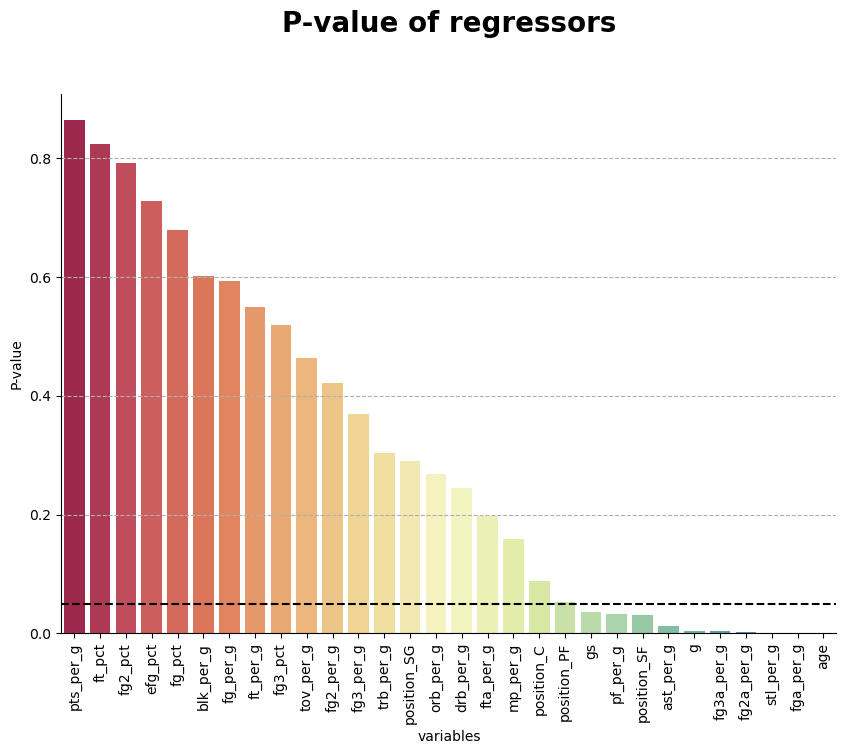

In [78]:
# Graficamos los p-valor
fig, ax = plt.subplots(figsize=(10,7))
coef_df = coef_df.sort_values(by='P>|t|', ascending = False)
ax = sns.barplot(x='variables', y='P>|t|', data=coef_df,
                 palette="Spectral")
ax.set_title('P-value of regressors', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('P-value', fontsize=10)
ax.set_xlabel('variables', fontsize=10)
plt.xticks(rotation=90, fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.axhline(y = 0.05, color = 'black', linestyle = '--')
plt.show()

Note that:
* Only some variables has significant coefficients:

**X:  gs, pf_per_g, ast_per_g, g, position_SG, fg3a_per_g, fg2a_per_g, fga_per_g,
       position_PG, stl_per_g, age**

To avoid the problems that scaling can introduce, we rescale the variables and repeat the fit for these new data.

In [80]:
from sklearn.preprocessing import StandardScaler

$z = \frac{(x - \mu)}{s}$

In [81]:
#we define the instance of the function to  scalar
scaler = StandardScaler()

In [83]:
#Select the numarical variables

In [91]:
nba_linal = nba.copy()
nba_linal = nba_linal.drop(['player','team_id'],axis=1)
nba_linal_numerical = nba_linal.select_dtypes(include=['float64','int64'])
#remove the variable salary
nba_linal_numerical = nba_linal_numerical.drop(['salary'],axis=1)
nba_linal_numerical_features = nba_linal_numerical.columns

In [93]:
print(nba_linal_numerical_features)

Index(['age', 'g', 'gs', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct',
       'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'fg2_per_g', 'fg2a_per_g',
       'fg2_pct', 'efg_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g',
       'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g',
       'tov_per_g', 'pf_per_g', 'pts_per_g'],
      dtype='object')


In [98]:
#we scale the variables
scaled = scaler.fit_transform(nba_linal_numerical)

In [99]:
nba_linal_numerical = pd.DataFrame(scaled, columns=nba_linal_numerical_features)

In [101]:
#We generate dummies variables with sacaled variables 

In [102]:
nba_linal_categorical = nba_linal.select_dtypes(include=['object'])
nba_linal_categorical = pd.get_dummies(nba_linal_categorical)
nba_linal_categorical

,position_C,position_PF,position_PG,position_SF,position_SG
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,1,0,0
...,...,...,...,...,...
398,0,1,0,0,0
399,0,0,0,0,1
400,0,0,0,0,1
401,0,0,1,0,0


In [103]:
#We generate the data set to fit the model
nba_linal = pd.concat([nba_linal_numerical,df_dummies], axis=1)
X = nba_linal.copy()
y = nba['salary']

In [104]:
# We build the  modelo add one constant
X = sm.add_constant(X)
model_scaled = sm.OLS(y,X)
results_scaled = model_scaled.fit()

In [106]:
print(f"ECM: {results_scaled.mse_resid}")

ECM: 31832279898386.11


In [113]:
print(results_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     24.78
Date:                Sat, 01 Jul 2023   Prob (F-statistic):           8.41e-71
Time:                        12:58:06   Log-Likelihood:                -6820.6
No. Observations:                 403   AIC:                         1.370e+04
Df Residuals:                     372   BIC:                         1.383e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.904e+06   1.01e+06      6.862      

In [115]:
#We plot the coefficients at 95% confidence
coef_df_scaled = coef_summary(results_scaled)

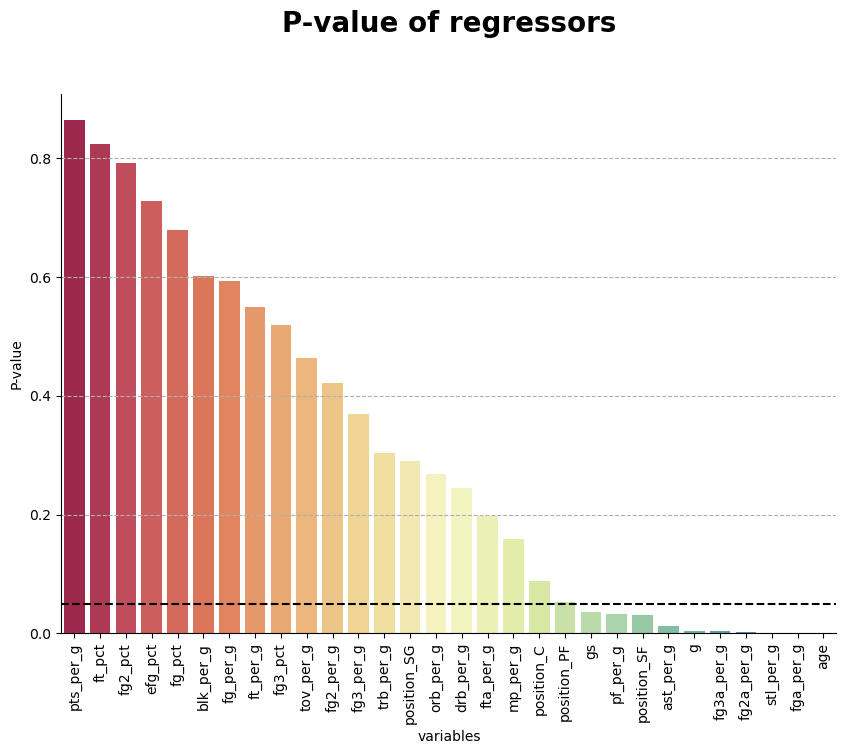

In [117]:
# Graficamos los p-valor
fig, ax = plt.subplots(figsize=(10,7))
coef_df_scaled = coef_df_scaled.sort_values(by='P>|t|', ascending = False)
ax = sns.barplot(x='variables', y='P>|t|', data=coef_df_scaled,
                 palette="Spectral")
ax.set_title('P-value of regressors', fontweight='bold', fontsize=20, y=1.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('P-value', fontsize=10)
ax.set_xlabel('variables', fontsize=10)
plt.xticks(rotation=90, fontsize = 10 )
plt.yticks( fontsize = 10 )
plt.axhline(y = 0.05, color = 'black', linestyle = '--')
plt.show()

In [118]:
print(f"MSE Scaled: {results_scaled.rsquared}",'vs.',f"MSE: {results.rsquared}" )
print(f"Adj MSE Scaled: {results_scaled.rsquared_adj}",'vs.',f" Adj MSE: {results.rsquared_adj}" )
print(f"p-value Scaled: {results_scaled.f_pvalue}",'vs.',f" p-value: {results.f_pvalue}" )

MSE Scaled: 0.6664671283621361 vs. MSE: 0.6664671283621362
Adj MSE Scaled: 0.6395693161332761 vs.  Adj MSE: 0.6395693161332763
p-value Scaled: 8.414522406673801e-71 vs.  p-value: 8.414522406673801e-71


The large number of variables and the existence of a high correlation between several of them cause the estimated coefficients to have high variance and many of them are not significant in statistical terms. **Regularization** techniques can help us improve this situation.

## 3. Regularization

$y_{salary} = MES + \lambda(\alpha \sum_{j \in J}^{}\beta + (1-\alpha) \sum_{j \in J}^{}\beta^{2})$

$\lambda$ controls the entire penalty, while $\alpha$ controls the **Elastic Net** penalty and acts as a bridge between **Lasso** and **Ridge**

With the parameter we indicate what type of model we want to work with:

* Ridge: $\alpha = 0$ 

* Lasso:  $\alpha = 1$
 
* Elastic Net: $0 < \alpha < 1$
 

We perform a partition between training and test datasets with the train_test_split function from the *sklearn* library

### Partición Train y Test

In [122]:
from sklearn.model_selection import train_test_split

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [127]:
print(f'- size of X train  is {X_train.shape[0]}')
print(f'- size of X test  is {X_test.shape[0]}')
print(f'- size of y train  is {y_train.shape[0]}')
print(f'- size of y test  is {y_test.shape[0]}')

- size of X train  is 282
- size of X test  is 121
- size of y train  is 282
- size of y test  is 121


### **Lasso regularization**